In [1]:
from Research_Final.DatasetLoader_mine2 import DatasetLoader
import os
import numpy as np

In [2]:
parent = 'multipletimeseriesforecasting/preprocessed-data/'

path = os.path.join(parent, 'SanFranciscoTraffic/traffic_weekly_dataset.tsf')

dl = DatasetLoader('SanFranciscoTraffic', path)

matrix_1_original = dl.dataset_load_and_preprocess("original")
matrix_1_norm = dl.dataset_load_and_preprocess("normalized")
print(matrix_1_norm.shape)

---------------------------------------------------
Dataset name:  SanFranciscoTraffic
Dataset contains missing values?  False
--------------------------
---------------------------------------------------
Dataset name:  SanFranciscoTraffic
Dataset contains missing values?  False
--------------------------
(862, 104)


In [3]:
sample_len = int(matrix_1_norm.shape[1]*(0.3))
print("Sample_len total", sample_len)

np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(sample_len), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

Sample_len total 31
[24 39 52 27 44  2 21 62 41 50 38 54 35 26 57 49  3 40 36 10 56 19 34 60] [17 55 53 48 33 51 31]


In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

from torchhd import functional
from torchhd import embeddings
from torchhd import cos_similarity

from scipy.special import softmax

import time

d=10000
models = 8

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_NonLinear_Sin(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_NonLinear_Sin, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(size, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)

    def encode(self, x): # encoding a value
        for i in range(len(x)):
            x[i] = float(x[i])
        enc = self.project(x)
        sample_hv = torch.cos(enc + self.bias) * torch.sin(enc) 
        return functional.hard_quantize(sample_hv)

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x
        

    def forward(self, x):
        enc = torch.reshape(self.encode(x), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions
    
model = MultiModel_With_NonLinear_Sin(2, 40) # 1 class, 5
#model = model.to(device)

#mse = torchmetrics.MeanSquaredError()
    
# Model training

start_time = time.time()
#main()
#print("--- %s seconds ---" % (time.time() - start_time))

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in tqdm(range(10)): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for i in sets_training:
            pred = []
            samples = matrix_1_norm[:, i:i+40]
            labels = matrix_1_norm[:, i+40]
            #print(f"sample: {samples}, label:{labels}")
            #samples = samples.to(device) # pass sample and label (1 at a time)
            #labels = labels.to(device)
            
            for n in range(samples.shape[0]):
                label = torch.tensor(labels[n])
                sample = torch.tensor(samples[n, :])
                #print(x)
                #samples = 
                samples_hv = model.encode(sample) # Encode the inputs
                #print(f"sample_hv:{samples_hv}")
                model.model_update(samples_hv, label) # Pass input and label to train

                predictions_testing = model(sample) # Pass samples from test to model (forward function)
                pred.append(predictions_testing[0])
                #predictions_testing = predictions_testing
                #label = label
                mse.update(predictions_testing[0], label.unsqueeze(dim=0))
                #mse.update(predictions_testing.cpu(), label)

        print(f"Training mean squared error of {(mse.compute().item()):.3f}")

 10%|█         | 1/10 [01:39<14:58, 99.86s/it]

Training mean squared error of 0.022


 20%|██        | 2/10 [03:00<11:47, 88.43s/it]

Training mean squared error of 0.017


 30%|███       | 3/10 [04:20<09:51, 84.57s/it]

Training mean squared error of 0.015


 40%|████      | 4/10 [05:40<08:17, 82.99s/it]

Training mean squared error of 0.014


 50%|█████     | 5/10 [07:00<06:49, 81.95s/it]

Training mean squared error of 0.013


 60%|██████    | 6/10 [08:21<05:26, 81.50s/it]

Training mean squared error of 0.012


 70%|███████   | 7/10 [09:42<04:03, 81.19s/it]

Training mean squared error of 0.012


 80%|████████  | 8/10 [11:17<02:51, 85.63s/it]

Training mean squared error of 0.011


 90%|█████████ | 9/10 [12:51<01:28, 88.40s/it]

Training mean squared error of 0.011


100%|██████████| 10/10 [14:25<00:00, 86.56s/it]

Training mean squared error of 0.011


In [12]:
pred_multihd = []
original_hd = []

with torch.no_grad():
    mse = torchmetrics.MeanSquaredError()
    for i in tqdm(sets_testing):
        pred = []
        samples = matrix_1_norm[:, i:i+40]
        labels = matrix_1_norm[:, i+40]
        for n in range(samples.shape[0]):
            label = torch.tensor(labels[n])
            sample = torch.tensor(samples[n, :])
            # Pass samples from test to model (forward function)
            predictions = model(sample)
            pred.append(predictions[0])
            # predictions = predictions * TARGET_STD + TARGET_MEAN # What is target
            # labels = labels * TARGET_STD + TARGET_MEAN
            mse.update(predictions[0], label.unsqueeze(dim=0))
            # dif_hd.append(np.absolute(label-predictions))
            pred_multihd.append(predictions)
            original_hd.append(label)

    print(
        f"Testing mean squared error of testing {(mse.compute().item()):.3f}")

100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

Testing mean squared error of testing 0.033


In [13]:
# For RegHD
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchmetrics
from tqdm import tqdm

from torchhd import functional
from torchhd import embeddings

import numpy as np
# Model based on RegHD application for Single model regression -> No comparing which cluster


class SingleModel_With_NonLinear_Sin(nn.Module):
    def __init__(self, num_classes, size, d):
        super(SingleModel_With_NonLinear_Sin, self).__init__()

        self.lr = 0.00001  # alpha
        self.M = torch.zeros(1, d).double()  # Model initializes in 0
        # 5 features, 10000 dimensions = hypervectors like weights?
        self.project = embeddings.Projection(size, d).double()
        # Normal distributions mean=0.0, std=1.0
        self.project.weight.data.normal_(0, 1)
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi)  # bias

    def encode(self, x):  # encoding a value
        for i in range(len(x)):
            x[i] = float(x[i])
        enc = self.project(x)
        sample_hv = torch.cos(enc + self.bias) * torch.sin(enc)
        return functional.hard_quantize(sample_hv)

    def model_update(self, x, y):  # update # y = no hv
        # Model + alpha*(Error)*(x)
        update = self.M + self.lr * (y - (F.linear(x, self.M))) * x
        # update = update.mean(0) # Mean by columns
        self.M = update  # New

    def forward(self, x):
        enc = self.encode(x)
        # Multiply enc (x) * weights (Model) = Dot product
        res = F.linear(enc, self.M)
        return res  # Return the resolutions


model_2 = SingleModel_With_NonLinear_Sin(2, 40, 10000)  # 1 class, 5
# main()
# print("--- %s seconds ---" % (time.time() - start_time))

with torch.no_grad():  # disabled gradient calculation because were doing it manually
    for _ in tqdm(range(10)):  # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for i in (sets_training):  # Calculated at random
            pred = []
            samples = matrix_1_norm[:, i:i+40]
            labels = matrix_1_norm[:, i+40]
            # print(f"sample: {samples}, label:{labels}")
            # samples = samples.to(device) # pass sample and label (1 at a time)
            # labels = labels.to(device)

            for n in range(samples.shape[0]):
                label = torch.tensor(labels[n])
                sample = torch.tensor(samples[n, :])
                # samples =
                samples_hv = model_2.encode(sample)  # Encode the inputs
                # print(f"sample_hv:{samples_hv}")
                # Pass input and label to train
                model_2.model_update(samples_hv, label)

                # Pass samples from test to model (forward function)
                predictions_testing = model_2(sample)
                # print(predictions_testing.item())
                pred.append(predictions_testing)
                # predictions_testing = predictions_testing
                # label = label
                mse.update(predictions_testing, label.unsqueeze(dim=0))
                # mse.update(predictions_testing.cpu(), label)
        print(
            f"Training mean squared error of {(mse.compute().item()):.3f}")


pred_hd = []

with torch.no_grad():
    mse = torchmetrics.MeanSquaredError()
    for i in tqdm(sets_testing):
        pred = []
        samples = matrix_1_norm[:, i:i+40]
        labels = matrix_1_norm[:, i+40]
        for n in range(samples.shape[0]):
            label = torch.tensor(labels[n])
            sample = torch.tensor(samples[n, :])
            # Pass samples from test to model (forward function)
            predictions = model_2(sample)
            pred.append(predictions)
            # predictions = predictions * TARGET_STD + TARGET_MEAN # What is target
            # labels = labels * TARGET_STD + TARGET_MEAN
            mse.update(predictions, label.unsqueeze(dim=0))
            # dif_hd.append(np.absolute(label-predictions))
            pred_hd.append(predictions)

    print(
        f"Testing mean squared error of testing {(mse.compute().item()):.3f}")

 10%|█         | 1/10 [00:36<05:28, 36.52s/it]

Training mean squared error of 0.022


 20%|██        | 2/10 [01:11<04:43, 35.38s/it]

Training mean squared error of 0.016


 30%|███       | 3/10 [01:47<04:11, 35.86s/it]

Training mean squared error of 0.015


 40%|████      | 4/10 [02:19<03:26, 34.50s/it]

Training mean squared error of 0.013


 50%|█████     | 5/10 [02:51<02:47, 33.54s/it]

Training mean squared error of 0.013


 60%|██████    | 6/10 [03:28<02:18, 34.69s/it]

Training mean squared error of 0.012


 70%|███████   | 7/10 [04:06<01:47, 35.76s/it]

Training mean squared error of 0.012


 80%|████████  | 8/10 [04:41<01:10, 35.32s/it]

Training mean squared error of 0.011


 90%|█████████ | 9/10 [05:12<00:34, 34.20s/it]

Training mean squared error of 0.011


100%|██████████| 10/10 [05:44<00:00, 34.43s/it]


Training mean squared error of 0.011


100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

Testing mean squared error of testing 0.031


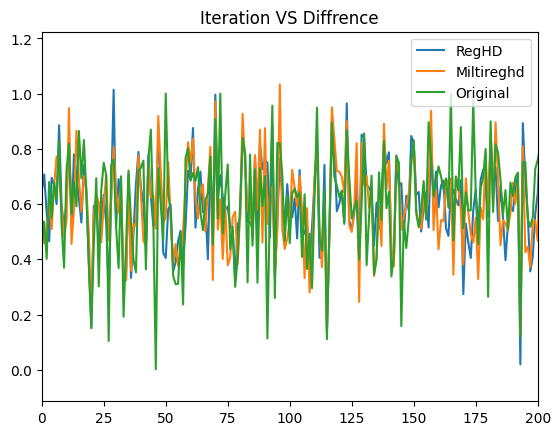

In [14]:
import matplotlib.pyplot as plt

y = list(range(0,len(pred_hd)))

reghd = [num.item() for num in pred_hd]
multireghd = [num.item() for num in pred_multihd]
original = [num.item() for num in original_hd]

plt.title("Iteration VS Diffrence")
plt.plot(y, reghd, "-")
plt.plot(y, multireghd, "-")
plt.plot(y, original, "-")
plt.legend(["RegHD", 'Miltireghd', "Original"])
plt.xlim(0,200)
plt.xlim(0,200)
plt.show()

# Lets compare other encodings

In [16]:
from torchhd import bind

d=10000
models = 8
ts = matrix_1_norm.shape[0]

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_Data(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_Data, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(size, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)
        self.time_series = functional.random_hv(ts, d) # Whic sensor it comes from

    def encode(self, x, ts): # encoding a value
        for i in range(len(x)):
            x[i] = float(x[i])
        enc = self.project(x)
        sample_hv = torch.cos(enc + self.bias) * torch.sin(enc) 
        return bind(functional.hard_quantize(sample_hv), self.time_series[ts])

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x
        

    def forward(self, x, ts):
        enc = torch.reshape(self.encode(x, ts), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions
    
model_3 = MultiModel_With_Data(2, 40) # 1 class, 5

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in tqdm(range(10)): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for i in sets_training:
            pred = []
            samples = matrix_1_norm[:, i:i+40]
            labels = matrix_1_norm[:, i+40]
            #print(f"sample: {samples}, label:{labels}")
            #samples = samples.to(device) # pass sample and label (1 at a time)
            #labels = labels.to(device)
            
            for n in range(samples.shape[0]):
                label = torch.tensor(labels[n])
                sample = torch.tensor(samples[n, :])
                #print(x)
                #samples = 
                samples_hv = model_3.encode(sample, n) # Encode the inputs
                #print(f"sample_hv:{samples_hv}")
                model_3.model_update(samples_hv, label) # Pass input and label to train

                predictions_testing = model_3(sample, n) # Pass samples from test to model (forward function)
                pred.append(predictions_testing[0])
                #predictions_testing = predictions_testing
                #label = label
                mse.update(predictions_testing[0], label.unsqueeze(dim=0))
                #mse.update(predictions_testing.cpu(), label)

        print(f"Training mean squared error of {(mse.compute().item()):.3f}")

 10%|█         | 1/10 [01:29<13:23, 89.30s/it]

Training mean squared error of 0.193


 20%|██        | 2/10 [03:00<12:05, 90.64s/it]

Training mean squared error of 0.073


 30%|███       | 3/10 [04:27<10:22, 88.90s/it]

Training mean squared error of 0.052


 40%|████      | 4/10 [05:53<08:45, 87.57s/it]

Training mean squared error of 0.045


 50%|█████     | 5/10 [07:17<07:11, 86.30s/it]

Training mean squared error of 0.041


 60%|██████    | 6/10 [08:42<05:43, 85.83s/it]

Training mean squared error of 0.039


 70%|███████   | 7/10 [10:09<04:19, 86.36s/it]

Training mean squared error of 0.037


 80%|████████  | 8/10 [11:37<02:53, 86.97s/it]

Training mean squared error of 0.036


 90%|█████████ | 9/10 [13:03<01:26, 86.48s/it]

Training mean squared error of 0.035


100%|██████████| 10/10 [14:28<00:00, 86.84s/it]


Training mean squared error of 0.034


  0%|          | 0/7 [00:00<?, ?it/s]


TypeError: forward() missing 1 required positional argument: 'ts'

In [19]:
multi_hd_ts = []

with torch.no_grad():
    mse = torchmetrics.MeanSquaredError()
    for i in tqdm(sets_testing):
        pred = []
        samples = matrix_1_norm[:, i:i+40]
        labels = matrix_1_norm[:, i+40]
        for n in range(samples.shape[0]):
            label = torch.tensor(labels[n])
            sample = torch.tensor(samples[n, :])
            # Pass samples from test to model (forward function)
            predictions = model_3(sample, n)
            pred.append(predictions[0])
            # predictions = predictions * TARGET_STD + TARGET_MEAN # What is target
            # labels = labels * TARGET_STD + TARGET_MEAN
            mse.update(predictions[0], label.unsqueeze(dim=0))
            # dif_hd.append(np.absolute(label-predictions))
            multi_hd_ts.append(predictions[0])

    print(
        f"Testing mean squared error of testing {(mse.compute().item()):.3f}")

100%|██████████| 7/7 [00:11<00:00,  1.60s/it]

Testing mean squared error of testing 0.070


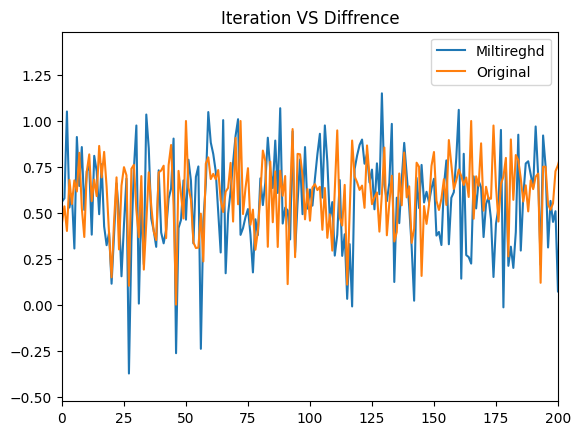

In [21]:
import matplotlib.pyplot as plt

y = list(range(0,len(pred_hd)))

multireghd_ts = [num.item() for num in multi_hd_ts]
original = [num.item() for num in original_hd]

plt.title("Iteration VS Diffrence")
plt.plot(y, multireghd_ts, "-")
plt.plot(y, original, "-")
plt.legend(['Miltireghd', "Original"])
plt.xlim(0,200)
plt.xlim(0,200)
plt.show()

In [22]:
from torchhd import bind

d=10000
models = 8
time = matrix_1_norm.shape[1]

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_TimeStamp(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_TimeStamp, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(size, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)
        self.time_stamp = functional.level_hv(time, d)

    def encode(self, x, start_time): # encoding a value
        for i in range(len(x)):
            x[i] = float(x[i])
        enc = self.project(x)
        sample_hv = torch.cos(enc + self.bias) * torch.sin(enc) 
        return bind(functional.hard_quantize(sample_hv), self.time_stamp[start_time])

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x
        

    def forward(self, x, time):
        enc = torch.reshape(self.encode(x, time), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions
    
model_4 = MultiModel_With_TimeStamp(2, 40) # 1 class, 5

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in tqdm(range(10)): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for i in sets_training:
            pred = []
            samples = matrix_1_norm[:, i:i+40]
            labels = matrix_1_norm[:, i+40]
            #print(f"sample: {samples}, label:{labels}")
            #samples = samples.to(device) # pass sample and label (1 at a time)
            #labels = labels.to(device)
            
            for n in range(samples.shape[0]):
                label = torch.tensor(labels[n])
                sample = torch.tensor(samples[n, :])
                #print(x)
                #samples = 
                samples_hv = model_4.encode(sample, i) # Encode the inputs
                #print(f"sample_hv:{samples_hv}")
                model_4.model_update(samples_hv, label) # Pass input and label to train

                predictions_testing = model_4(sample, i) # Pass samples from test to model (forward function)
                pred.append(predictions_testing[0])
                #predictions_testing = predictions_testing
                #label = label
                mse.update(predictions_testing[0], label.unsqueeze(dim=0))
                #mse.update(predictions_testing.cpu(), label)

        print(f"Training mean squared error of {(mse.compute().item()):.3f}")

 10%|█         | 1/10 [01:29<13:23, 89.28s/it]

Training mean squared error of 0.023


 20%|██        | 2/10 [02:54<11:35, 86.89s/it]

Training mean squared error of 0.017


 30%|███       | 3/10 [04:27<10:26, 89.46s/it]

Training mean squared error of 0.015


 40%|████      | 4/10 [05:56<08:57, 89.65s/it]

Training mean squared error of 0.014


 50%|█████     | 5/10 [07:22<07:20, 88.09s/it]

Training mean squared error of 0.013


 60%|██████    | 6/10 [08:46<05:47, 86.77s/it]

Training mean squared error of 0.012


 70%|███████   | 7/10 [10:09<04:16, 85.55s/it]

Training mean squared error of 0.012


 80%|████████  | 8/10 [11:39<02:54, 87.02s/it]

Training mean squared error of 0.012


 90%|█████████ | 9/10 [13:01<01:25, 85.51s/it]

Training mean squared error of 0.011


100%|██████████| 10/10 [14:24<00:00, 86.43s/it]

Training mean squared error of 0.011


In [24]:
multi_hd_time = []

with torch.no_grad():
    mse = torchmetrics.MeanSquaredError()
    for i in tqdm(sets_testing):
        pred = []
        samples = matrix_1_norm[:, i:i+40]
        labels = matrix_1_norm[:, i+40]
        for n in range(samples.shape[0]):
            label = torch.tensor(labels[n])
            sample = torch.tensor(samples[n, :])
            # Pass samples from test to model (forward function)
            predictions = model_4(sample, i)
            pred.append(predictions[0])
            # predictions = predictions * TARGET_STD + TARGET_MEAN # What is target
            # labels = labels * TARGET_STD + TARGET_MEAN
            mse.update(predictions[0], label.unsqueeze(dim=0))
            # dif_hd.append(np.absolute(label-predictions))
            multi_hd_time.append(predictions[0])

    print(
        f"Testing mean squared error of testing {(mse.compute().item()):.3f}")

100%|██████████| 7/7 [00:11<00:00,  1.67s/it]

Testing mean squared error of testing 0.032


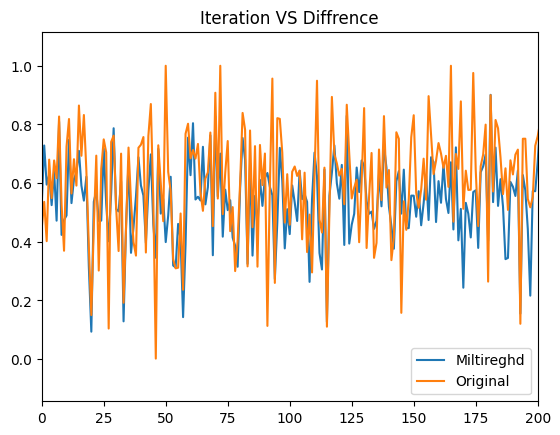

In [25]:
import matplotlib.pyplot as plt

y = list(range(0,len(pred_hd)))

multireghd_time = [num.item() for num in multi_hd_time]
original = [num.item() for num in original_hd]

plt.title("Iteration VS Diffrence")
plt.plot(y, multireghd_time, "-")
plt.plot(y, original, "-")
plt.legend(['Miltireghd', "Original"])
plt.xlim(0,200)
plt.xlim(0,200)
plt.show()

In [27]:
from torchhd import bind

d=10000
models = 8
time = matrix_1_norm.shape[1]
ts = matrix_1_norm.shape[0]

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_TimeStamp_TimeSeries(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_TimeStamp_TimeSeries, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(1, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)
        time_stamp_array = functional.level_hv(time, d)
        self.time_stamp = {}
        for i in range(time):
            self.time_stamp[i] = time_stamp_array[i]
        time_series_array = functional.random_hv(ts, d)
        self.time_series = {}
        for i in range(ts):
            self.time_series[i] = time_series_array[i]


    def encode(self, x, start_time, ts): # encoding a value
        sum_hdv = torch.zeros(d)
        for i in range(len(x)):
            x[i] = float(x[i])
            enc = torch.pow(self.project(torch.tensor([x[i]])), 6*x[i])
            time_enc = functional.bind(functional.hard_quantize(enc), self.time_stamp[start_time + i])
            if i == 0:
                sum_hdv = time_enc
            else:
                sum_hdv = functional.bundle(sum_hdv, time_enc)
        return bind(sum_hdv, self.time_series[ts])

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x
        

    def forward(self, x, time, ts):
        enc = torch.reshape(self.encode(x, time, ts), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions
    
model_5 = MultiModel_With_TimeStamp_TimeSeries(2, 40) # 1 class, 5

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in tqdm(range(10)): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for i in sets_training:
            pred = []
            samples = matrix_1_norm[:, i:i+40]
            labels = matrix_1_norm[:, i+40]

            for n in range(samples.shape[0]):
                label = torch.tensor(labels[n])
                sample = torch.tensor(samples[n, :]) 
                samples_hv = model_5.encode(sample, i, n) # Encode the inputs
                #print(f"sample_hv:{samples_hv}")
                model_5.model_update(samples_hv, label) # Pass input and label to train

                predictions_testing = model_5(sample, i, n) # Pass samples from test to model (forward function)
                pred.append(predictions_testing[0])
                #predictions_testing = predictions_testing
                #label = label
                mse.update(predictions_testing[0], label.unsqueeze(dim=0))
                #mse.update(predictions_testing.cpu(), label)

        print(f"Training mean squared error of {(mse.compute().item()):.3f}")

  0%|          | 0/10 [07:11<?, ?it/s]


KeyboardInterrupt: 

Really slow

In [ ]:
multi_hd_time_ts = []

with torch.no_grad():
    mse = torchmetrics.MeanSquaredError()
    for i in tqdm(sets_testing):
        pred = []
        samples = matrix_1_norm[:, i:i+40]
        labels = matrix_1_norm[:, i+40]
        for n in range(samples.shape[0]):
            label = torch.tensor(labels[n])
            sample = torch.tensor(samples[n, :])
            # Pass samples from test to model (forward function)
            predictions = model_5(sample, i, n)
            pred.append(predictions[0])
            # predictions = predictions * TARGET_STD + TARGET_MEAN # What is target
            # labels = labels * TARGET_STD + TARGET_MEAN
            mse.update(predictions[0], label.unsqueeze(dim=0))
            # dif_hd.append(np.absolute(label-predictions))
            multi_hd_time_ts.append(predictions[0])

    print(
        f"Testing mean squared error of testing {(mse.compute().item()):.3f}")

What if only choose the model closest to it?

Group similar users better?